# A computational model of the encoding of fear in the VMH
# Model 4: Non-exclusive feedback inhibition
23/11/2021

*Ryan Rahy*

In [1]:
# analysis
import nest
import numpy as np
import pandas as pd
import pyspike as spk
import scipy.stats as stats
import math

# plotting
import pylab
pylab.style.use('default')
pylab.rcParams['figure.figsize'] = [15, 10]

## Table of contents
1. [Network structure + properties](#structure)
    1. [Circuit structure](#structure)
    2. [Neurons and connections](#neurons)
    3. [Sensory input](#sensory_input)
2. [Network setup](#setup)
    1. [Connectivity matrix](#connectivity)
3. [Simulation run + results](#run_results)
	1. [Running the simulation](#run)
	2. [Single-trial results](#results)
    3. [Average results across trials](#average)


## Network structure + properties <a name='structure'></a>

### Circuit structure <a name='structure'></a>

To identify key network features underlying a sensory-thresholded switch between Assessment+ and Flight+ cells we built circuit models in NEST (Fardet et al., 2020) consisting of three major cell types (amygdala, VMH core, VMH shell) and introduced different network geometries and properties among them. This notebook covers the code and results for Model 4. The proposed circuit structure is shown in the following diagram.

![](circuit_structures/model_4_circuit_structure.jpg)

Neurons were modeled as leaky integrate-and-fire neurons with exponentially-shaped postsynaptic currents (Tsodyks, Uziel, and Markram, 2000) and Bernoulli synapses (static synapses with release probability prelease). All connections within and between populations followed a Bernoulli distribution (probability = $p_{connection}$). VMH core included two populations of excitatory neurons (N = 100 each Assessment and Flight neurons). Parameters were chosen based on previously reported in vitro slice electrophysiological properties of VMH core and shell neurons (core: resting membrane potential = -58.6 mV; action potential threshold = -43.1 mV; membrane time constant = 40.3 ms; shell: resting membrane potential = -56.5 mV; action potential threshold = -42 mV; membrane time constant = 41.6 ms; Yamamoto et al. 2018). VMH shell included a single population (N = 40 neurons; random connectivity Assessment-to-Flight/Flight-to-Assessment). Shell neurons are predisposed to having higher firing rates (Yamamoto et al. 2018) and were given higher noise frequencies than excitatory core neurons (core: 5 Hz; shell: 10 Hz). The amygdala consisted of a uniform population of non-interconnected excitatory neurons (N = 100) receiving sensory input and asymmetrically projecting onto both VMH core populations, with varying connection density to Flight neurons obtained by multiplying the amygdala-to-Flight $p_{connection}$ by a ratio $0 \le r_{amygdala\ Flight/Assessment} \le 1$. Weights of amygdala connections to VMH core were sampled randomly from a normal distribution (shown below), while delay values were sampled from a uniform distribution to introduce variability in the input received by VMH core. 

Because NEST does not allow for having both fast and slow transmission in the same synapse, excitatory rebound was introduced into our model by adding an intermediate population of neurons between shell and core with non-probabilistic release synapses and a slow excitatory effect (delay time, $0 \le t_{delay} \le 50\  ms$; rebound time constant, $0 \le \tau_{rebound} \le 50\  ms$; estimated from experimental data: $t_{delay} = 14\  ms$, $\tau_{rebound} = 10\  ms$, Wong et al., 2016). 

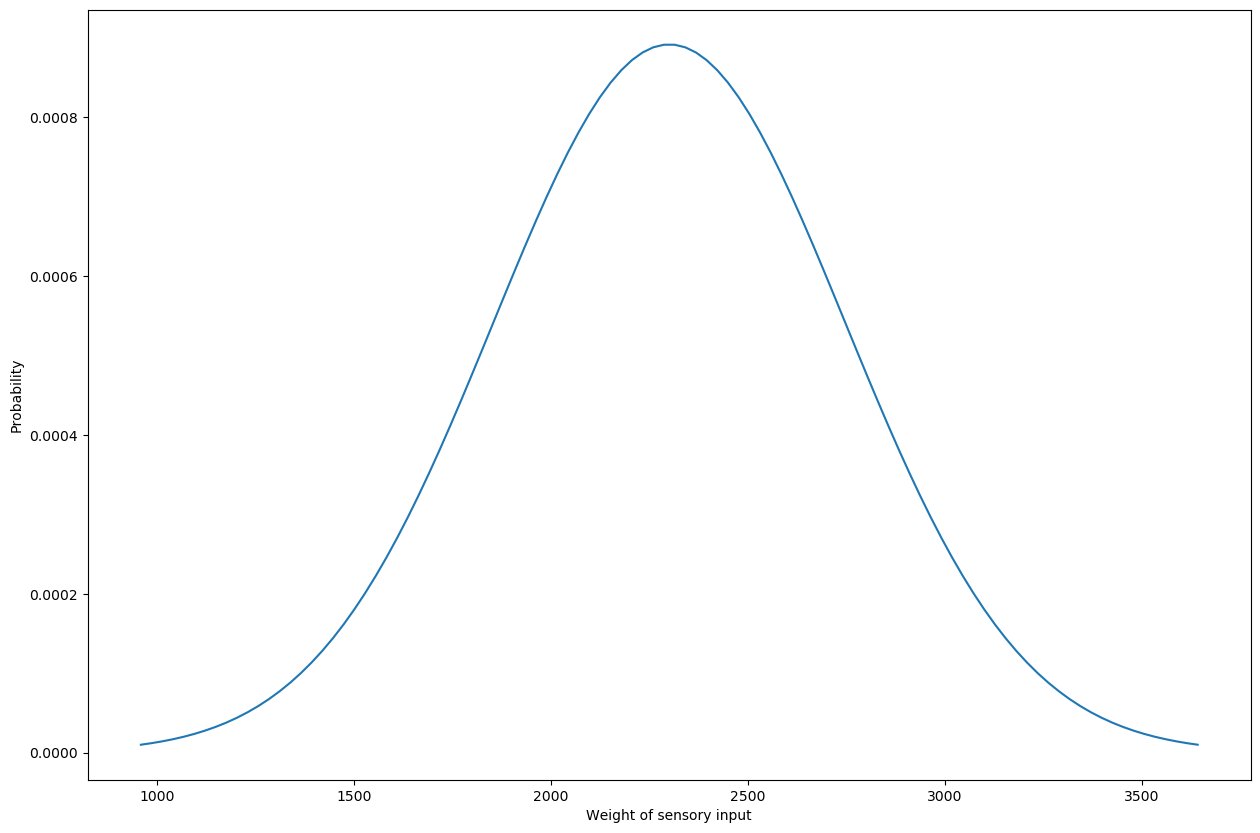

In [2]:
# define input weight distribution
mu = 2300.
variance = 200000.
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
pylab.plot(x, stats.norm.pdf(x, mu, sigma))
pylab.xlabel('Weight of sensory input')
pylab.ylabel('Probability')
pylab.show()

Sensory input was modelled using an inhomogeneous Poisson generator, which can generate spikes based on a varying firing rate function, described in the [Sensory input](#sensory_input) section. This generator is connected to a population of cells representing amygdalar cells, which are in turn connected to both core populations. 

The parameters of this model are set up as follows:

In [3]:
# computational models
neuron_model = 'iaf_psc_exp' # model used for neurons

default_synapse_model =  'bernoulli_synapse'  # default model used for most synapses
p_release = .8 # probability of release of Bernoulli synapses

# rebound properties
specific_synapse_model =  'static_synapse' # circuit-specific model used for some synapses
rebound_properties = {'E_L': -58.6, 'V_th': -43.1, 'tau_m': 10.}
rebound_delay = 14.

# amygdalar input properties
n_amygdala = 100 # number of cells in amygdala
p_amygdala = 0.8 # probability of connection from amydala to assessment+ population
r_amygdala = 0.7 # multiplication factor for probability of connection from amygdala to Flight+ cells
amygdala_delay = 500. # milliseconds, maximum delay from amygdala to core

# core properties
core_properties = {'E_L': -58.6, 'V_th': -43.1, 'tau_m': 40.3}  # properties of core neurons - source: Yamamoto et al, 2018
n_ass = n_fl = 100 # number of neurons in each core population
p_core = 0.25 # probability of connection between and within core populations
core_noise = 5. # Hz, frequency of intrinsic core neuron noise

# shell properties
shell_properties = {'E_L': -56.5, 'V_th': -42.0, 'tau_m': 41.6} # properties of shell neurons - source: Yamamoto et al, 2018
n_shell = 40 # number of neurons in each shell population
p_shell_core = p_core_shell = 0.5 # probability of connection from the shell to the core and vice versa
p_shell = 0.25 # probability of connection between and within shell populations
shell_noise = core_noise * 2 # Hz, frequency of intrinsic shell neuron noise

# connection weights
weight = 750. # default weight value - used for weight of sensory input to amygdala, core to shell, and noise
weight_ex = 200. # weight of excitatory connections within the core
weight_in = -1000. # weight of inhibitory connections from the shell
weight_rebound = weight * 2.5

### Sensory input <a name='sensory_input'></a>

To simulate the sensory input that a mouse experiences during approach-to-flight we employed an inhomogeneous Poisson process that generated spiking signals to the amygdala population based on a time-varying firing rate function $\lambda(t)$. In each trial (20 s) we used $\lambda(t)=max(f_{baseline},a_{model}t)$ for the first half of the trial $(0 \le t \lt 10\ s)$ to approximate the increasing sensory signal during approach behavior (assessment phase), and $\lambda(t)=max(f_{baseline},f_{max,model}-4a_{model}(t-10))$ for the remaining 10 s $(10 \le t \le 20\ s)$ to simulate the decreasing sensory signal during avoidance behavior (flight phase), where $f_{baseline}=40\ Hz$ sets the baseline level of input to the amygdalar cells, $f_{max, model}$ represents the maximum sensory input firing rate for each model (where $f_{max, Model\ 4} = 100\ Hz$), and $a_{model}=\frac{f_{max,model}}{10}$ is the slope for each model. Note that a mouse typically flees faster than it approaches a threat, hence the rapid drop in sensory input (Masferrer et al. 2020). We included multiple trials in a single simulation run to assess the consistency in the network response without resetting parameters. Each run of our simulation included 10 consecutive trials with inter-trial intervals of 6 s and buffer periods of 2 s at the beginning and the end. During the inter-trial intervals and buffer periods we used $\lambda(t)=f_{baseline}$ to represent a baseline level of sensory input to the amygdala. 

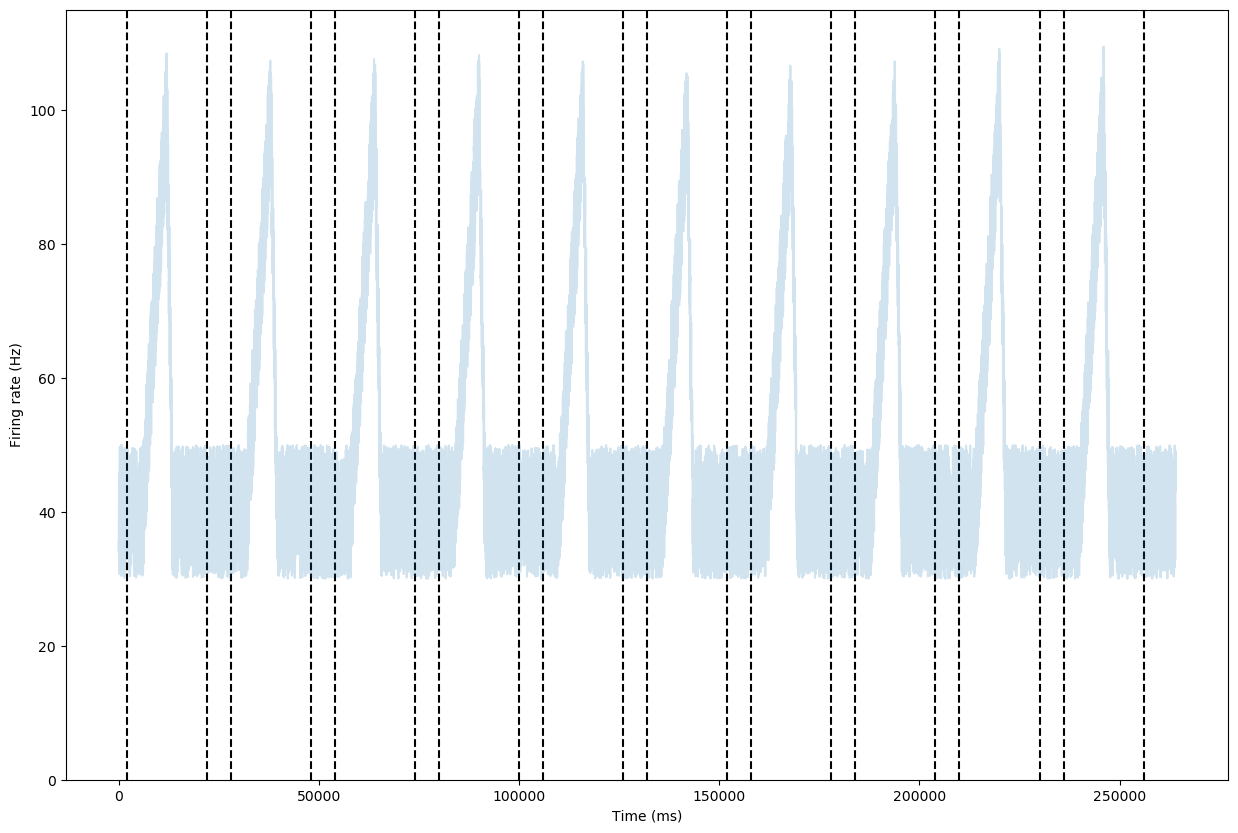

In [4]:
# simulation setup
buffer_period = 2 # seconds, length of a single buffer period
trial_period = 20 # seconds, length of a single trial
simulation_repeats = 10 # number of repeating trials in single simulation run
inter_trial_buffer = 3 # number of equivalents of the buffer period between trials
total_time = trial_period * simulation_repeats + buffer_period * (2 + inter_trial_buffer * simulation_repeats) # total time of the simulation

# define input
bin_size = .02 # seconds, length of timestep/bin used for sensory input and histograms of merged spike events
input_noise = 20 # Hz, range of random noise +/- input firing rate
plateau_value = 40. # Hz, baseline firing rate of sensory input 
max_value = 100. # Hz, maximum firing rate of sensory input
rate = max_value/(trial_period/2) # rate of increase of sensory input, such that maximum is at middle of the period of interest. Decrease after peak happens at 4x the rate
input_dict = {'rate_times': [10.] + [float(x) for x in np.arange(bin_size*1000, total_time*1000, bin_size*1000)], 
              'rate_values': ([plateau_value] * int(buffer_period/bin_size) + 
                              ([max(plateau_value, x * rate) for x in np.arange(0, trial_period/2, bin_size)] + 
                               [max(max_value - (x - trial_period/2) * (rate*4), plateau_value) for x in np.arange(trial_period/2, trial_period, bin_size)] + 
                              [plateau_value] * int((inter_trial_buffer * buffer_period)/bin_size)) * simulation_repeats + 
                              [plateau_value] * int(buffer_period/bin_size)) + input_noise/2 * (1 - 2 * np.random.random(int(total_time/bin_size)))}

# plot sensory input function
for i in range(simulation_repeats):
    start, end = [buffer_period + (buffer_period * inter_trial_buffer + trial_period) * i, buffer_period + (buffer_period * inter_trial_buffer + trial_period) * i + trial_period]
    pylab.axvline(x = start * 1000, color = 'black', ls = '--')
    pylab.axvline(x = end * 1000, color = 'black', ls = '--')

pylab.plot(input_dict['rate_times'], input_dict['rate_values'], alpha = 0.2)
pylab.ylim([0, max_value + 15])
pylab.xlabel('Time (ms)')
pylab.ylabel('Firing rate (Hz)')
pylab.show()

The simulation is run over a total of {{total_time}} s - the first and last {{buffer_period}} s are buffering periods to allow the network to stabilize before and after the simulation trials take place. In this case, {{simulation_repeats}} trials were performed, each lasting {{trial_period}} s and followed by {{inter_trial_buffer * buffer_period}} s buffer periods.

## Network setup <a name='setup'></a>

Connections were created between neurons based on the model shown in the first figure and using the corresponding properties from the previous section. Spike detectors are connected to both shell and core flight+ and assessment+ populations.

In [24]:
nest.ResetKernel()
nest.SetKernelStatus({'local_num_threads': 4})

nest.SetDefaults(default_synapse_model, {'p_transmit': p_release}) # set the probability of release as default for all Bernoulli synapses

# create spike generator
sensory_input = nest.Create('inhomogeneous_poisson_generator', params = input_dict)

# create neuron populations
# core
ass = nest.Create(neuron_model, n_ass, params = core_properties)
fl = nest.Create(neuron_model, n_fl, params = core_properties)
rebound = nest.Create(neuron_model, n_shell, params = rebound_properties)
# shell
shell = nest.Create(neuron_model, n_shell, params = shell_properties)
# amygdala
amygdala = nest.Create(neuron_model, n_amygdala)

# create synapses
# create all-to-all excitatory synapses from input to basomedial amygdala cells cells
nest.Connect(sensory_input, amygdala, syn_spec = {'weight': weight})
# create probabilistic and weight-varying excitatory synapses from input to Assessment+ population
nest.Connect(amygdala, ass, {'rule': 'pairwise_bernoulli', 'p': p_amygdala}, syn_spec = {'model': default_synapse_model, 'weight': {'distribution': 'normal', 'mu': mu, 'sigma': sigma}, 'delay': {'distribution': 'uniform', 'low': 0.1, 'high': amygdala_delay}})
nest.Connect(amygdala, fl, {'rule': 'pairwise_bernoulli', 'p': p_amygdala * r_amygdala}, syn_spec = {'model': default_synapse_model, 'weight': {'distribution': 'normal', 'mu': mu, 'sigma': sigma}, 'delay': {'distribution': 'uniform', 'low': 0.1, 'high': amygdala_delay}})
# create probabilistic excitatory synapses within Assessment+ and Flight+ populations
nest.Connect(ass, ass, {'rule': 'pairwise_bernoulli', 'p': p_core}, {'model': default_synapse_model, 'weight': weight_ex})
nest.Connect(fl, fl, {'rule': 'pairwise_bernoulli', 'p': p_core}, {'model': default_synapse_model, 'weight': weight_ex})
# create probabilistic excitatory synapses between Assessment+ and Flight+ populations
nest.Connect(ass, fl, {'rule': 'pairwise_bernoulli', 'p': p_core}, {'model': default_synapse_model, 'weight': weight_ex})
nest.Connect(fl, ass, {'rule': 'pairwise_bernoulli', 'p': p_core}, {'model': default_synapse_model, 'weight': weight_ex})
# create probabilistic inhibitory synapses between Assessment+ and Flight+ populations through the shell
nest.Connect(ass, shell, {'rule': 'pairwise_bernoulli', 'p': p_core_shell}, syn_spec = {'model': default_synapse_model, 'weight': weight})
nest.Connect(fl, shell, {'rule': 'pairwise_bernoulli', 'p': p_core_shell}, syn_spec = {'model': default_synapse_model, 'weight': weight})
nest.Connect(shell, fl, {'rule': 'pairwise_bernoulli', 'p': p_shell_core}, syn_spec = {'model': default_synapse_model, 'weight': weight_in})
nest.Connect(shell, ass, {'rule': 'pairwise_bernoulli', 'p': p_shell_core}, syn_spec = {'model': default_synapse_model, 'weight': weight_in})
# create probabilistic inhibitory synapses between and within Assessment+ and Flight+ shell populations
nest.Connect(shell, shell, {'rule': 'pairwise_bernoulli', 'p': p_shell}, {'model': default_synapse_model, 'weight': weight_in})
# create excitatory synapses from shell to Flight+ cells through rebound population in the core
# create one-to-one connections from shell Flight+-connecting population to rebound population
nest.Connect(shell, rebound, 'one_to_one', syn_spec = {'model': specific_synapse_model, 'weight': weight_rebound, 'delay': rebound_delay})
# create connections between rebound and Flight+ population that overlap with shell to Flight+ connections
for x, y in nest.GetStatus(nest.GetConnections(shell, fl), ['source', 'target']):
    nest.Connect(rebound[(x - n_shell - n_ass - n_fl - 2):(x - n_shell - n_ass - n_fl - 1)], fl[(y - n_fl - 2):(y - n_fl - 1)], syn_spec = {'model': specific_synapse_model, 'weight': weight_rebound})

# create noise generator
noise_excitatory = nest.Create('poisson_generator', 1, {'rate': core_noise})
nest.Connect(noise_excitatory, ass, syn_spec = {'weight': weight, 'delay': {'distribution': 'uniform', 'low': 0.1, 'high': 5.0}})
nest.Connect(noise_excitatory, fl, syn_spec = {'weight': weight, 'delay': {'distribution': 'uniform', 'low': 0.1, 'high': 5.0}})
nest.Connect(noise_excitatory, rebound, syn_spec = {'weight': weight, 'delay': {'distribution': 'uniform', 'low': 0.1, 'high': 5.0}})
noise_inhibitory = nest.Create('poisson_generator', 1, {'rate': shell_noise})
nest.Connect(noise_inhibitory, shell, syn_spec = {'weight': weight, 'delay': {'distribution': 'uniform', 'low': 0.1, 'high': 5.0}})

# collect data
ass_spikedetector = nest.Create('spike_detector', params = {'withgid': True, 'withtime': True})
fl_spikedetector = nest.Create('spike_detector', params = {'withgid': True, 'withtime': True})
rebound_spikedetector = nest.Create('spike_detector', params = {'withgid': True, 'withtime': True})
shell_spikedetector = nest.Create('spike_detector', params = {'withgid': True, 'withtime': True})
input_spikedetector = nest.Create('spike_detector', params = {'withgid': True, 'withtime': True})

nest.Connect(ass, ass_spikedetector)
nest.Connect(fl, fl_spikedetector)
nest.Connect(rebound, rebound_spikedetector)
nest.Connect(shell, shell_spikedetector)
nest.Connect(amygdala, input_spikedetector)

### Connectivity matrix <a name='connectivity'></a>

A connectivity matrix of the resulting network is generated to get an overview of the connections between the different populations.

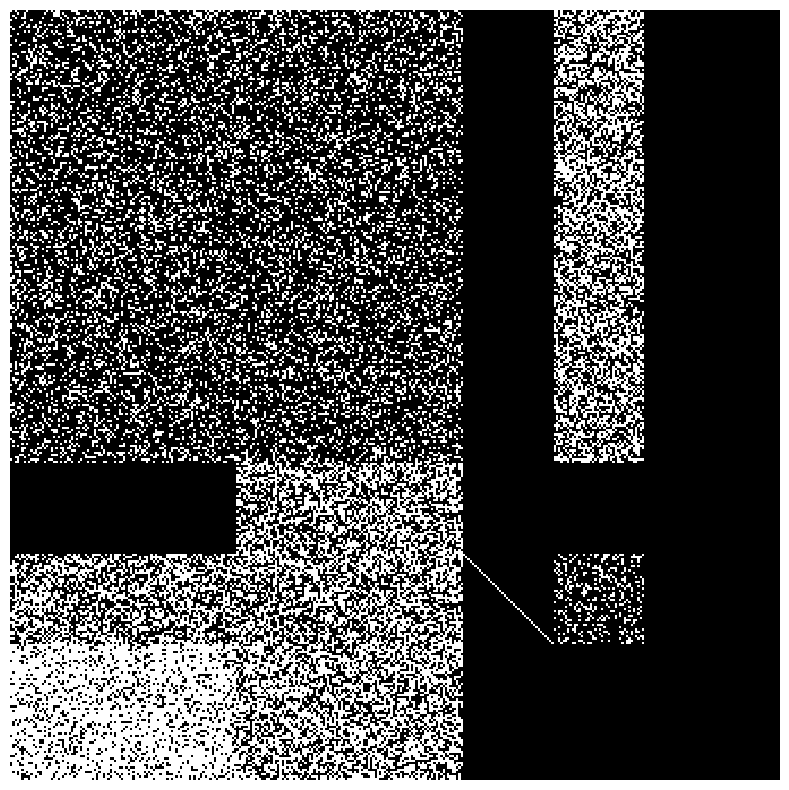

In [25]:
network_connections = pd.DataFrame(nest.GetConnections())#.iloc[:, 0:2]
conn_matrix = np.asarray(pd.crosstab(network_connections.iloc[:, 0], network_connections.iloc[:, 1], margins = False))[1:341, :340]

pylab.imshow(conn_matrix, cmap = 'gray')
pylab.axis('off')
pylab.show()

## Simulation run + results <a name='run_results'></a>
### Running the simulation <a name='run'></a>

The following code chunk runs the simulation and extracts the spike firing data of all the cells in the network.

In [26]:
# simulation control
nest.Simulate(total_time * 1000.)

# process results
dSD = nest.GetStatus(ass_spikedetector,keys="events")[0]
ass_evs = dSD["senders"]
ass_ts = dSD["times"]

dSD = nest.GetStatus(fl_spikedetector,keys="events")[0]
fl_evs = dSD["senders"]
fl_ts = dSD["times"]

dSD = nest.GetStatus(rebound_spikedetector,keys="events")[0]
rebound_evs = dSD["senders"]
rebound_ts = dSD["times"]

dSD = nest.GetStatus(shell_spikedetector,keys="events")[0]
shell_evs = dSD["senders"]
shell_ts = dSD["times"]

dSD = nest.GetStatus(input_spikedetector,keys="events")[0]
input_evs = dSD["senders"]
input_ts = dSD["times"]

ass_spiketrains = [spk.SpikeTrain(ass_ts[ass_evs == ass + 1], [0.0, total_time * 1000.]) for ass in range(n_ass)]
fl_spiketrains = [spk.SpikeTrain(fl_ts[fl_evs == fl + n_ass + 1], [0.0, total_time * 1000.]) for fl in range(n_fl)]

### Results <a name='results'></a>

After the simulation is run, for each population, the histogram of merged spike events was calculated over the entire run by combining the spiking activity of each population’s neurons. The following graphs show this firing data over the entire run with individual trials marked between the dashed lines. Merged spike events histogram calculations were done using the PySpike python package (Mulansky and Kreuz 2016) with a bin size of 20 ms.

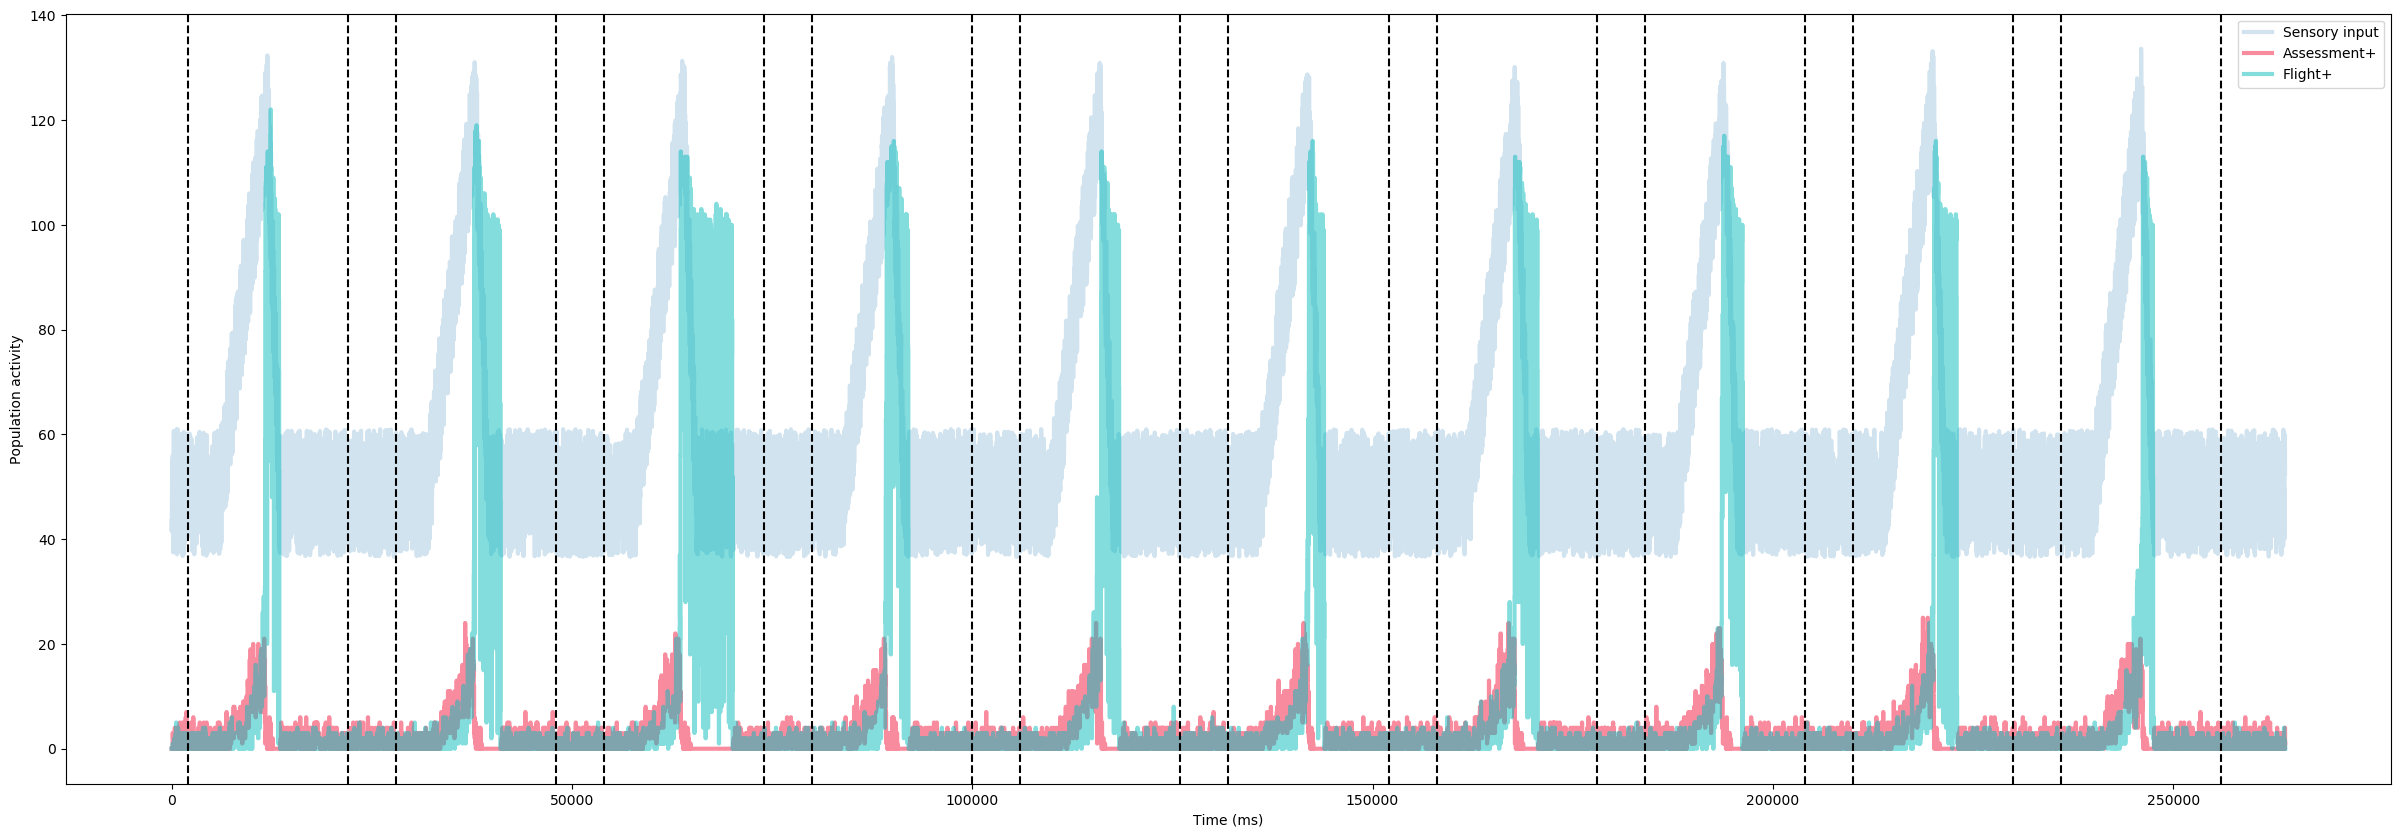

In [27]:
# get Assessment+ and Flight+ plottable data
ass_x, ass_y = spk.psth(ass_spiketrains, bin_size * 1000.).get_plottable_data()
fl_x, fl_y = spk.psth(fl_spiketrains, bin_size * 1000.).get_plottable_data()

# plot entire run
fig = pylab.figure(frameon = False)
fig.set_size_inches(30, 10)
pylab.plot(input_dict['rate_times'], [(x/max_value) * max(ass_y + fl_y) for x in input_dict['rate_values']], label = 'Sensory input', alpha = 0.2, linewidth = 3)
pylab.plot(ass_x, ass_y, label = 'Assessment+', color = '#F21B3F', alpha = 0.5, linewidth = 3)
pylab.plot(fl_x, fl_y, label = 'Flight+', color = '#08BDBD', alpha = 0.5, linewidth = 3)

for i in range(simulation_repeats):
    start, end = [buffer_period + (buffer_period * inter_trial_buffer + trial_period) * i, buffer_period + (buffer_period * inter_trial_buffer + trial_period) * i + trial_period]
    pylab.axvline(x = start * 1000, color = 'black', ls = '--')
    pylab.axvline(x = end * 1000, color = 'black', ls = '--')

pylab.legend()
# pylab.xlim([0, total_time*1000])
pylab.xlabel('Time (ms)')
pylab.ylabel('Population activity')
pylab.show()

To look at each trial alone:

Trial 0


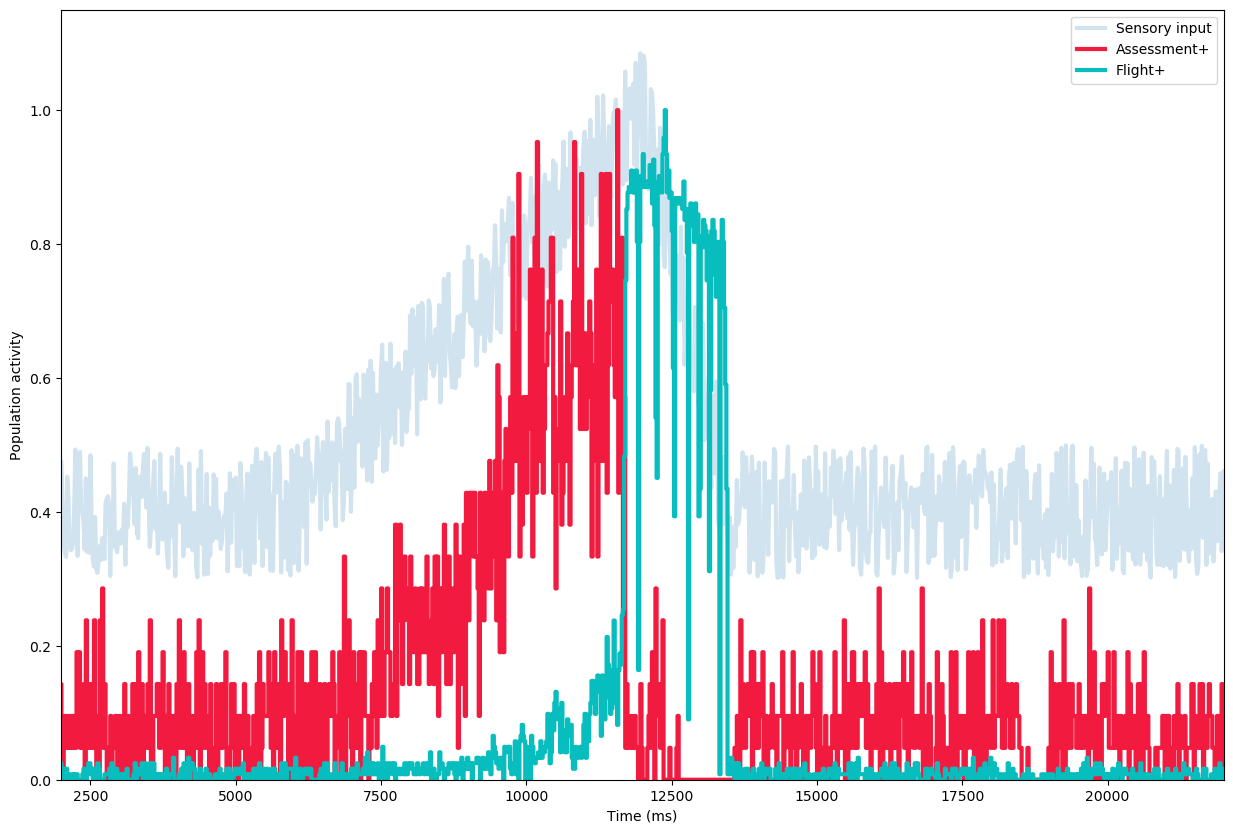

Trial 1


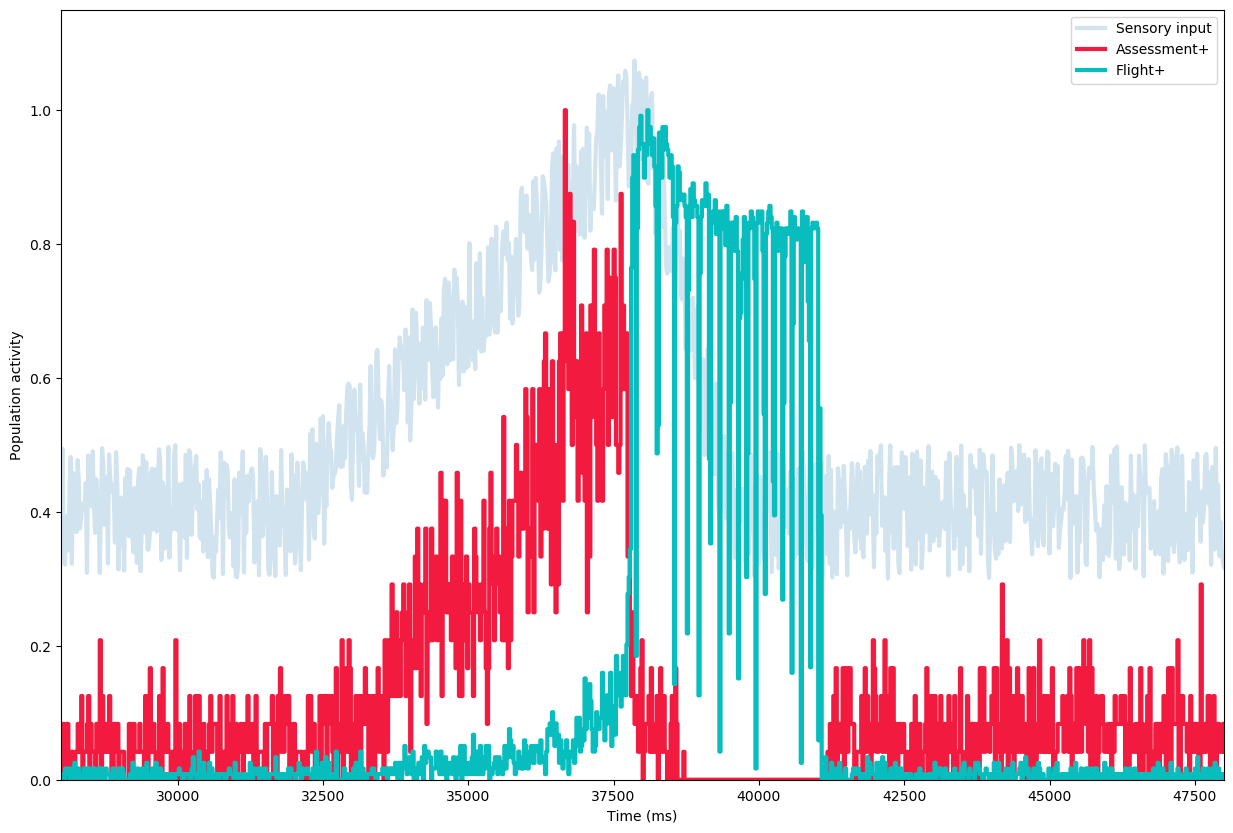

Trial 2


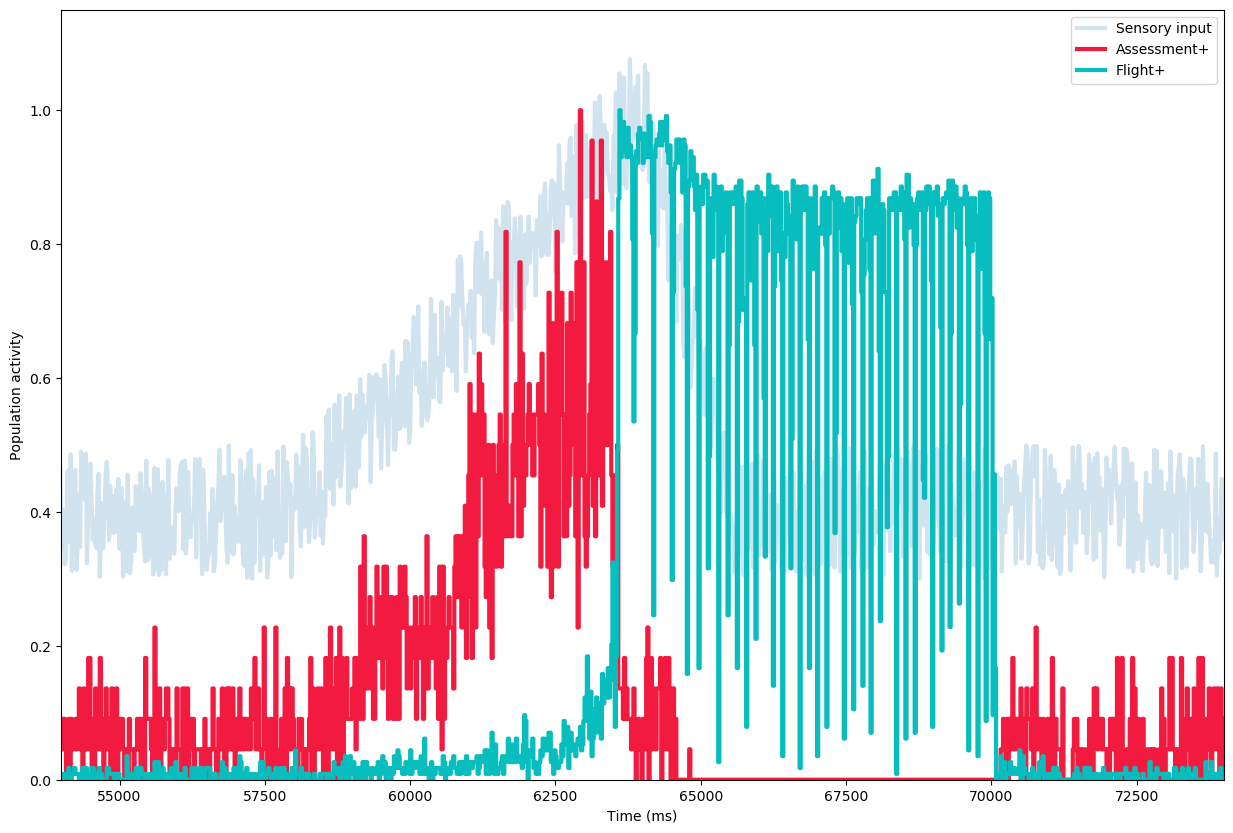

Trial 3


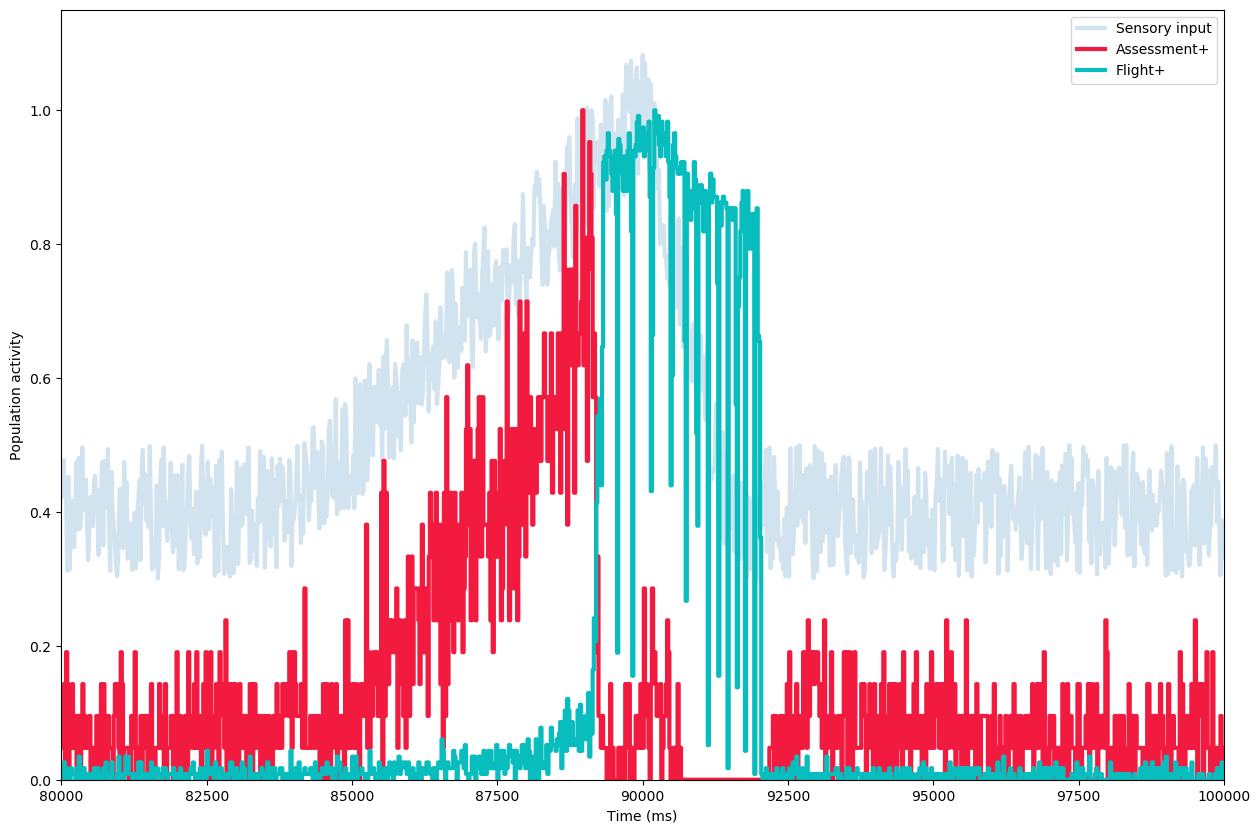

Trial 4


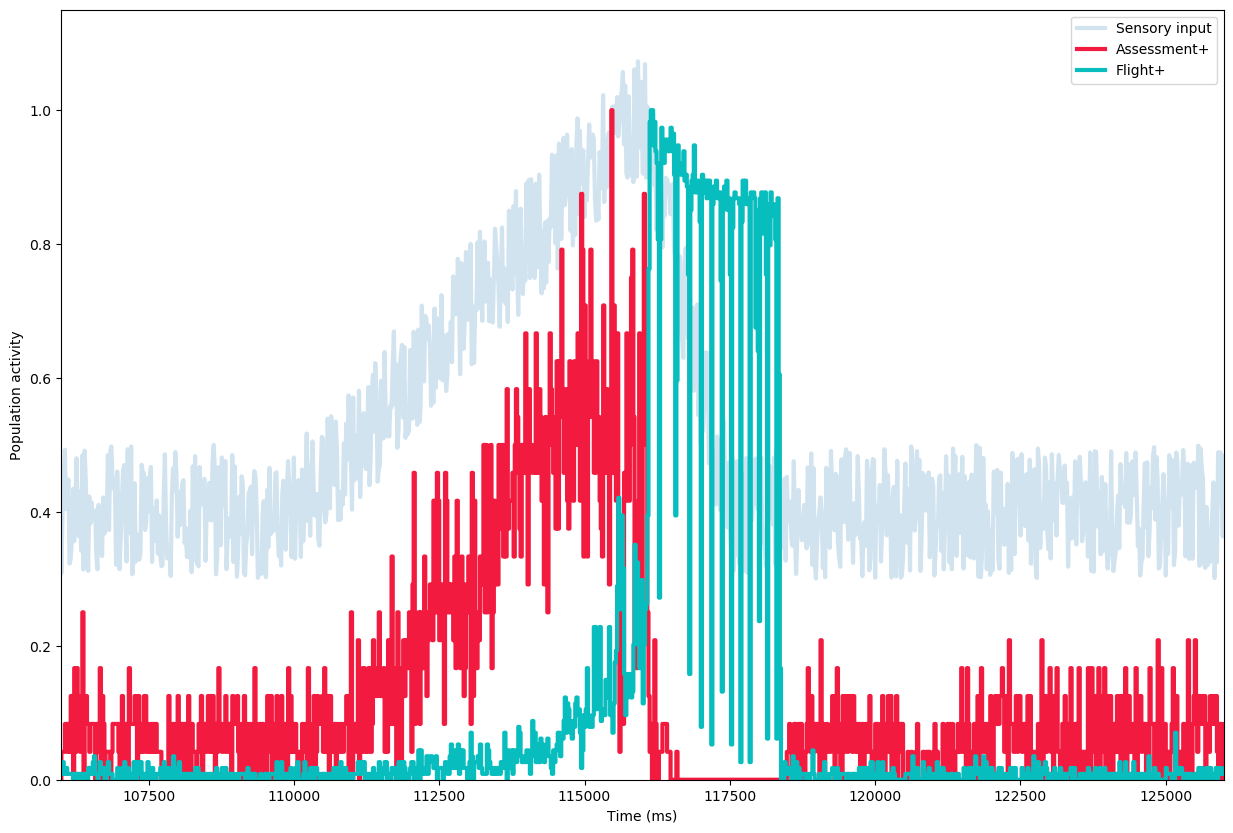

Trial 5


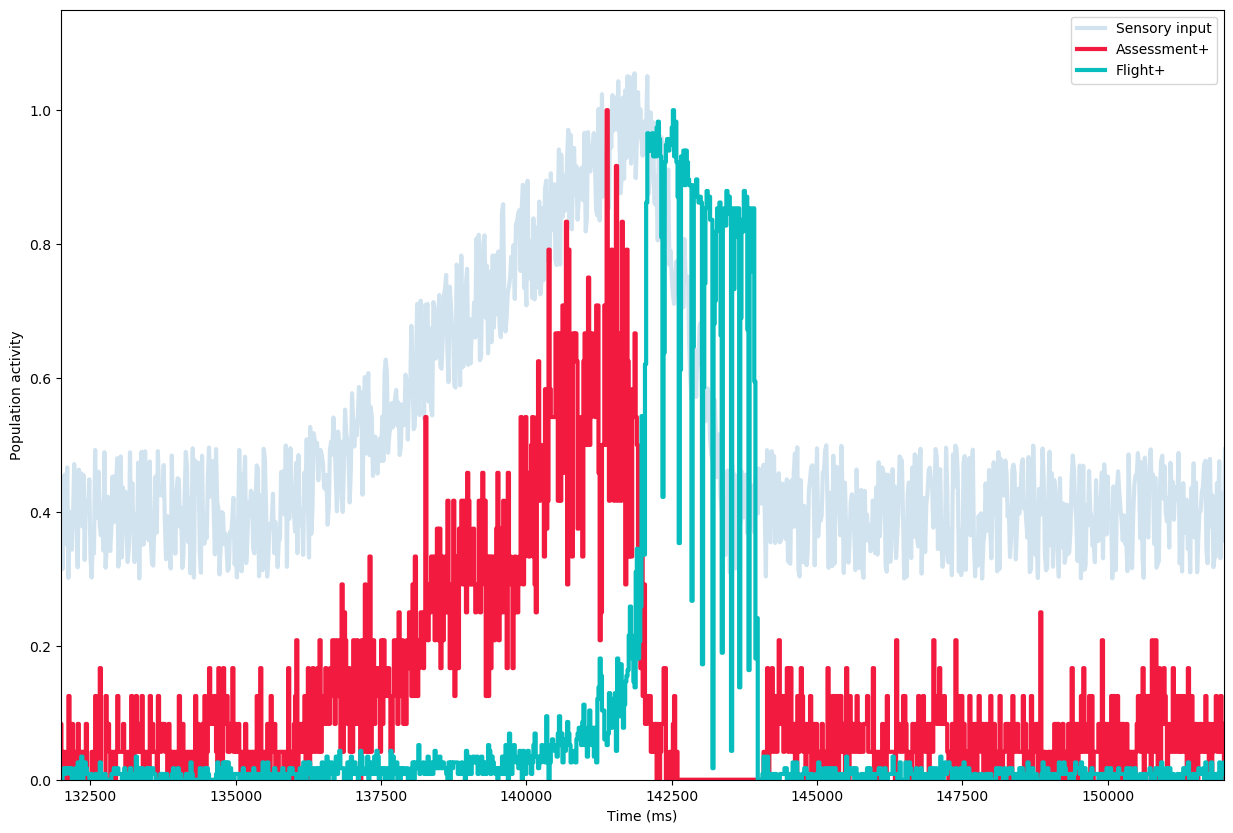

Trial 6


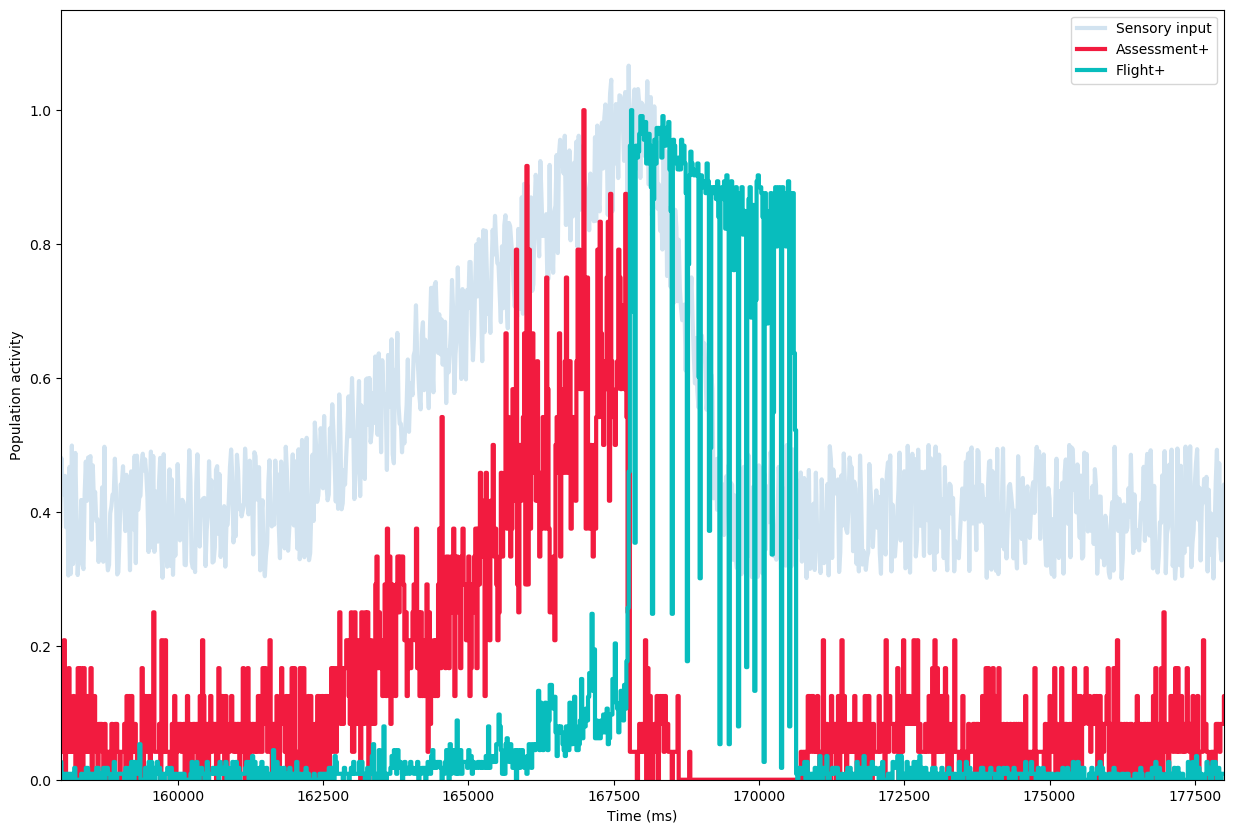

Trial 7


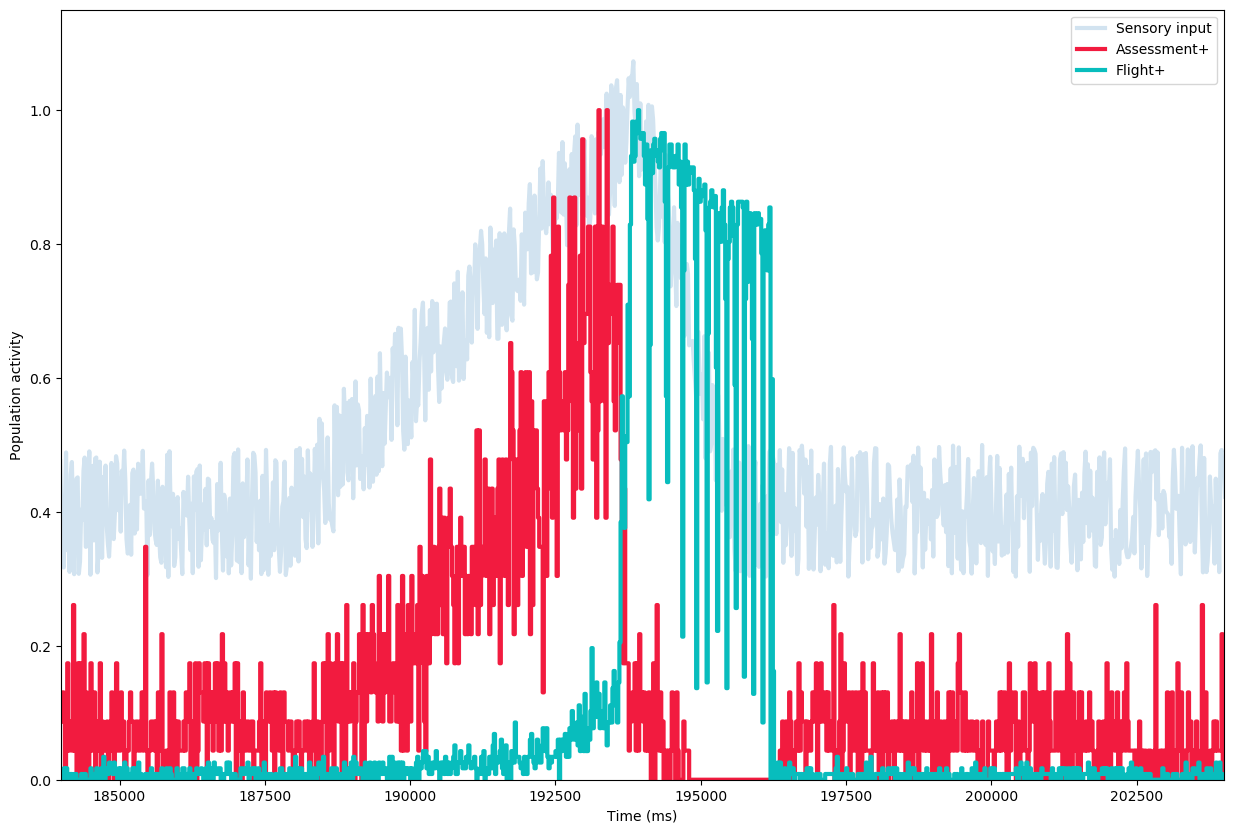

Trial 8


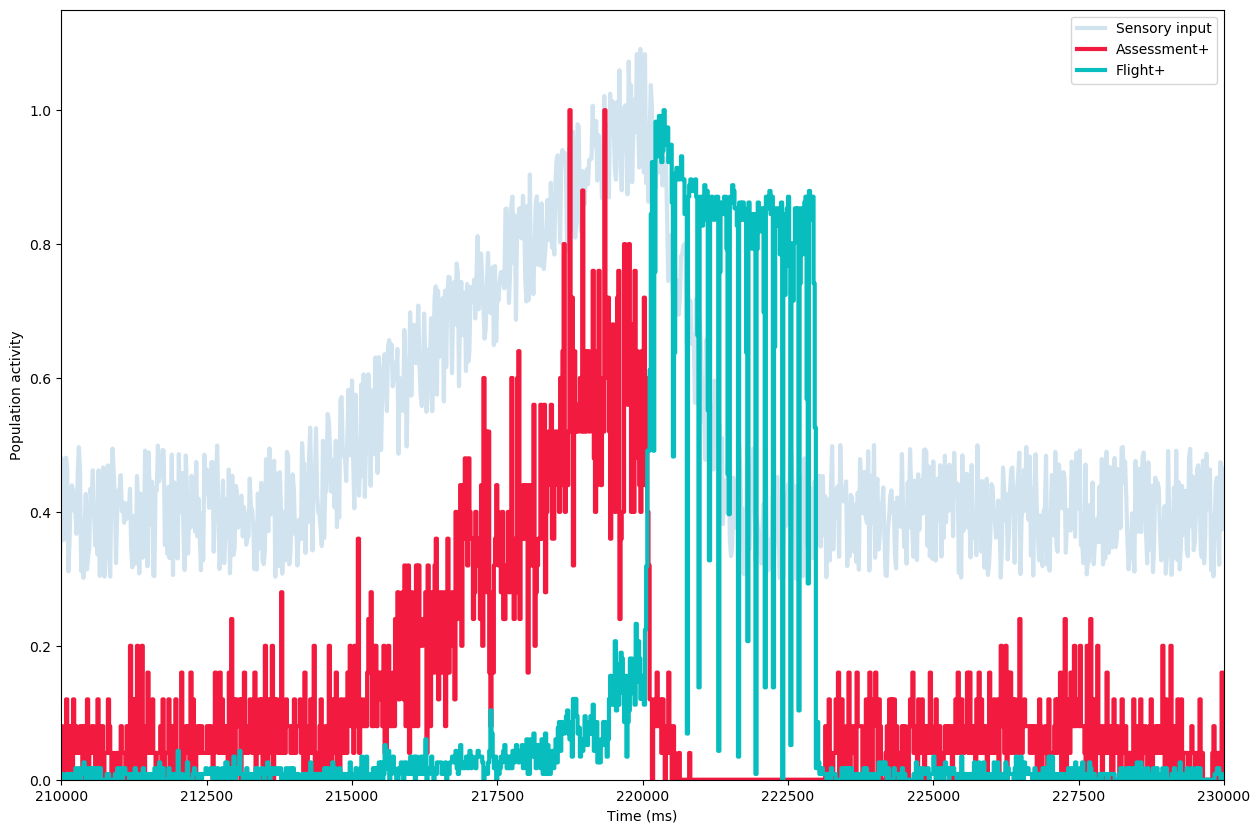

Trial 9


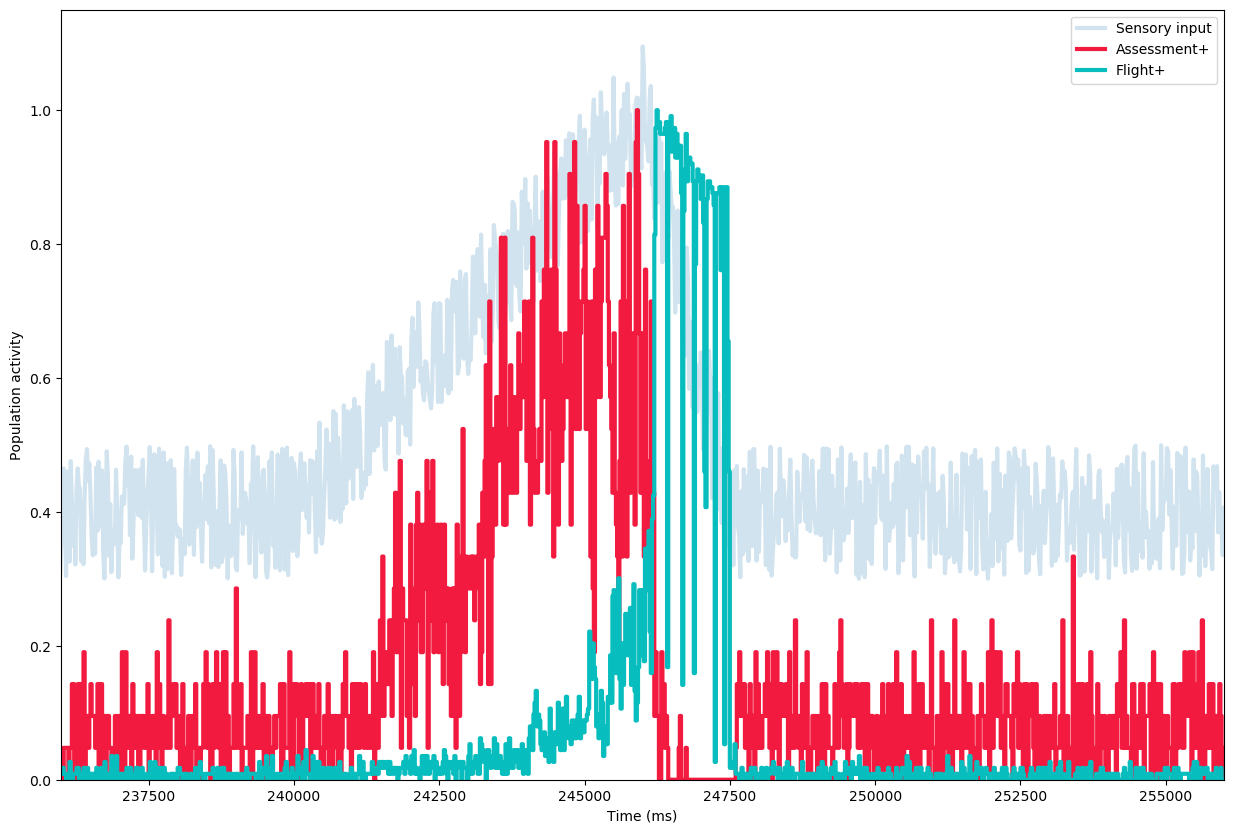

In [28]:
for i in range(simulation_repeats):
    print('Trial', i)
    start, end = [buffer_period + (buffer_period * inter_trial_buffer + trial_period) * i, buffer_period + (buffer_period * inter_trial_buffer + trial_period) * i + trial_period]
    pylab.clf()
    pylab.plot(input_dict['rate_times'], input_dict['rate_values']/max_value, label = 'Sensory input', alpha = 0.2, linewidth = 3)
    pylab.plot(ass_x, ass_y/max(ass_y[int(start/bin_size*2):int(end/bin_size*2)]), label = 'Assessment+', color = '#F21B3F', linewidth = 3)
    pylab.plot(fl_x, fl_y/max(fl_y[int(start/bin_size*2):int(end/bin_size*2)]), label = 'Flight+', color = '#08BDBD', linewidth = 3)
    pylab.legend()
    pylab.xlabel('Time (ms)')
    pylab.ylabel('Population activity')
    pylab.xlim([start * 1000, end * 1000])
    pylab.ylim([0, 1.15])
    pylab.show()

Individual cell firing activities were also obtained by calculating the PSTH for each using only the firing of each individual cell. The results are shown in the following heatmap:

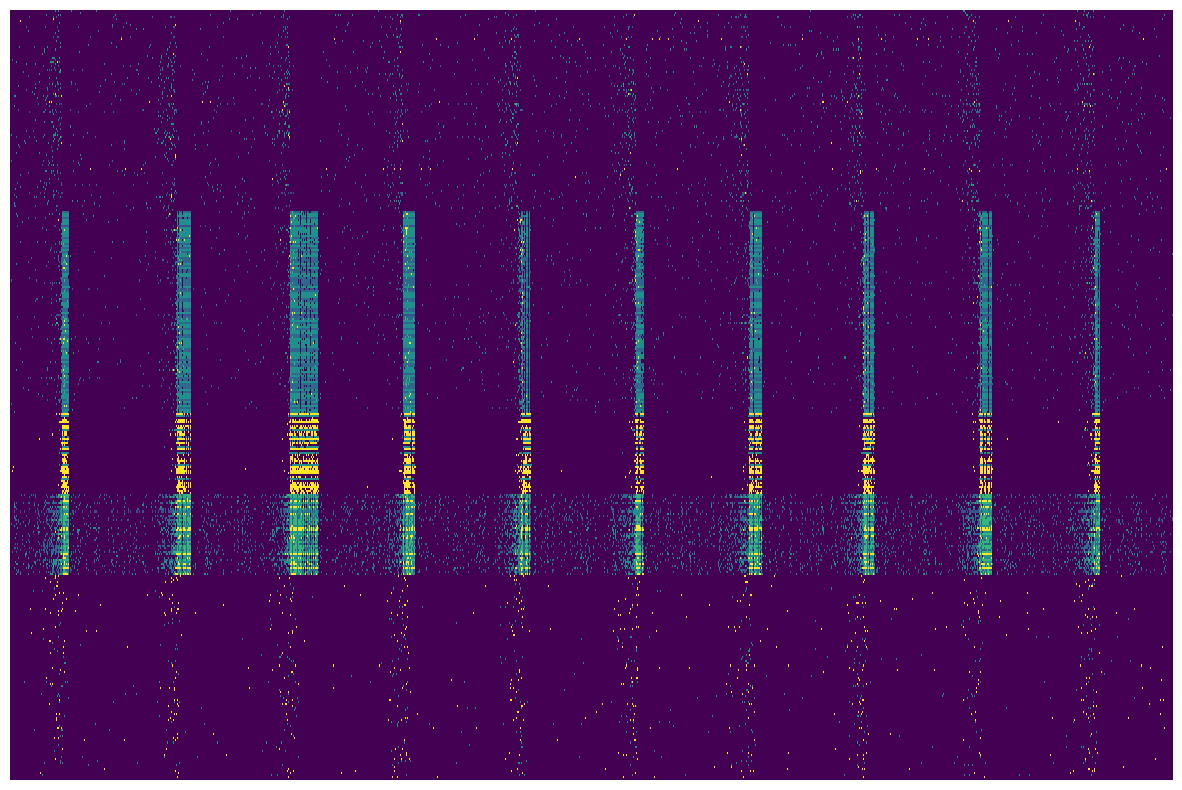

In [38]:
t_start, t_end = [0, total_time]
start_index, end_index = [int(t_start/bin_size), int(t_end/bin_size)]

n_cells = n_ass + n_fl + n_shell * 2 + n_amygdala
all_evs = np.array(ass_evs.tolist() + fl_evs.tolist() + rebound_evs.tolist() + shell_evs.tolist() + input_evs.tolist())
all_ts = np.array(ass_ts.tolist() + fl_ts.tolist() + rebound_ts.tolist() + shell_ts.tolist() + input_ts.tolist())

all_cells = np.zeros([n_cells, end_index - start_index])
all_peak_time = []

for cell in range(2, n_cells + 1):
    core_x, core_y = spk.psth([spk.SpikeTrain(all_ts[all_evs == cell+1], [0.0, total_time * 1000])], bin_size * 1000).get_plottable_data()
    core_y = core_y[::2][start_index:end_index]
    all_cells[cell - 2, ] = core_y/max(core_y)
    
pylab.imshow(all_cells, cmap = 'viridis', aspect = 'auto')
pylab.axis('off')
pylab.show()

### Average firing patterns across trials <a name='average'></a>

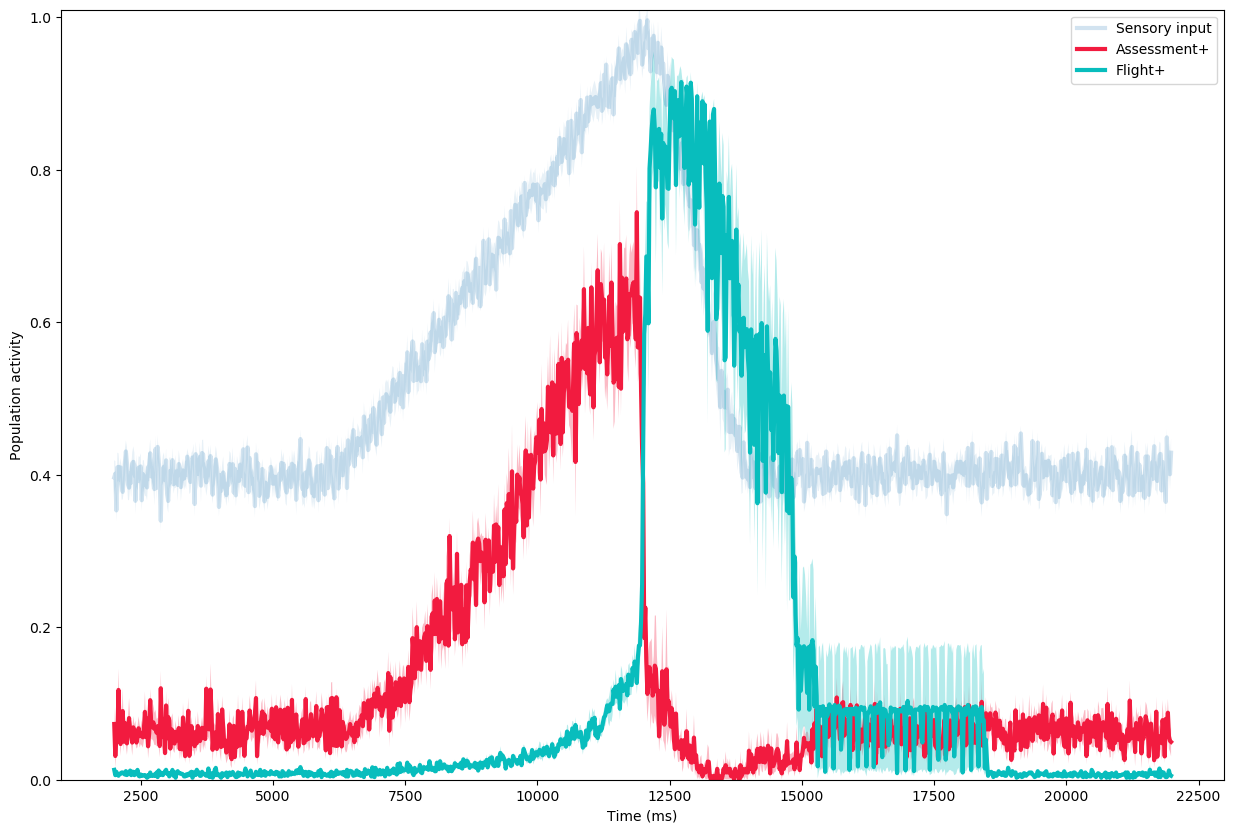

In [39]:
# get average firing pattern across trials
trial_length = int(trial_period + buffer_period * inter_trial_buffer)
b = max_value - (-4 * rate) * (trial_period/2 + buffer_period)

all_input = []
all_ass_y = []
all_fl_y = []

switch_times = []

# during each increase/decrease phase of the sensory input
for trial in range(simulation_repeats):
    start = int((buffer_period + plateau_value/rate + trial * trial_length)/bin_size * 2)
    end = int(((plateau_value - b)/(-4 * rate) + trial * trial_length)/bin_size * 2)
    switch = (start + np.argmax((ass_y[start:end] - fl_y[start:end]) < -.25*max(ass_y.tolist() + fl_y.tolist()))) * bin_size/2
    switch_times += [switch]
    
    start = round((switch - trial_period/2)/bin_size*2)
    end = round((switch + trial_period/2)/bin_size*2)
    
    all_ass_y += [ass_y[start:end][::2]/max(ass_y[start:end][::2])]
    all_fl_y += [fl_y[start:end][::2]/max(fl_y[start:end][::2])]
    all_input += [input_dict['rate_values'][int(start/2):int(end/2)]/max_value]

all_ass_x = ass_x[::2][int(buffer_period/bin_size):int((trial_period + buffer_period)/bin_size)]
all_fl_x = fl_x[::2][int(buffer_period/bin_size):int((trial_period + buffer_period)/bin_size)]

mean_ass_y = np.mean(all_ass_y, axis = 0)
mean_fl_y = np.mean(all_fl_y, axis = 0)
mean_amygdala = np.mean(all_input, axis = 0)

err_ass_y = np.std(all_ass_y, axis = 0)/math.sqrt(simulation_repeats)
err_fl_y = np.std(all_fl_y, axis = 0)/math.sqrt(simulation_repeats)
err_input = np.std(all_input, axis = 0)/math.sqrt(simulation_repeats)

pylab.fill_between(input_dict['rate_times'][int(buffer_period/bin_size):int((trial_period + buffer_period)/bin_size)], mean_amygdala + err_input, mean_amygdala - err_input, alpha = 0.1)
pylab.plot(input_dict['rate_times'][int(buffer_period/bin_size):int((trial_period + buffer_period)/bin_size)], mean_amygdala, label = 'Sensory input', alpha = 0.2, linewidth = 3)
pylab.fill_between(all_ass_x, mean_ass_y + err_ass_y, mean_ass_y - err_ass_y, facecolor = '#F21B3F', alpha = 0.3)
pylab.plot(all_ass_x, mean_ass_y, label = 'Assessment+', color = '#F21B3F', linewidth = 3)
pylab.fill_between(all_fl_x, mean_fl_y + err_fl_y, mean_fl_y - err_fl_y, facecolor = '#08BDBD', alpha = 0.3)
pylab.plot(all_fl_x, mean_fl_y, label = 'Flight+', color = '#08BDBD', linewidth = 3)
# pylab.xlim([buffer_period, buffer_period + trial_period])
pylab.ylim([0, 1.01])
pylab.xlabel('Time (ms)')
pylab.ylabel('Population activity')
pylab.legend()

<ipython-input-40-dd5361e56a2e>:11: RuntimeWarning:invalid value encountered in true_divide


(-0.5, 999.5, 379.5, -0.5)

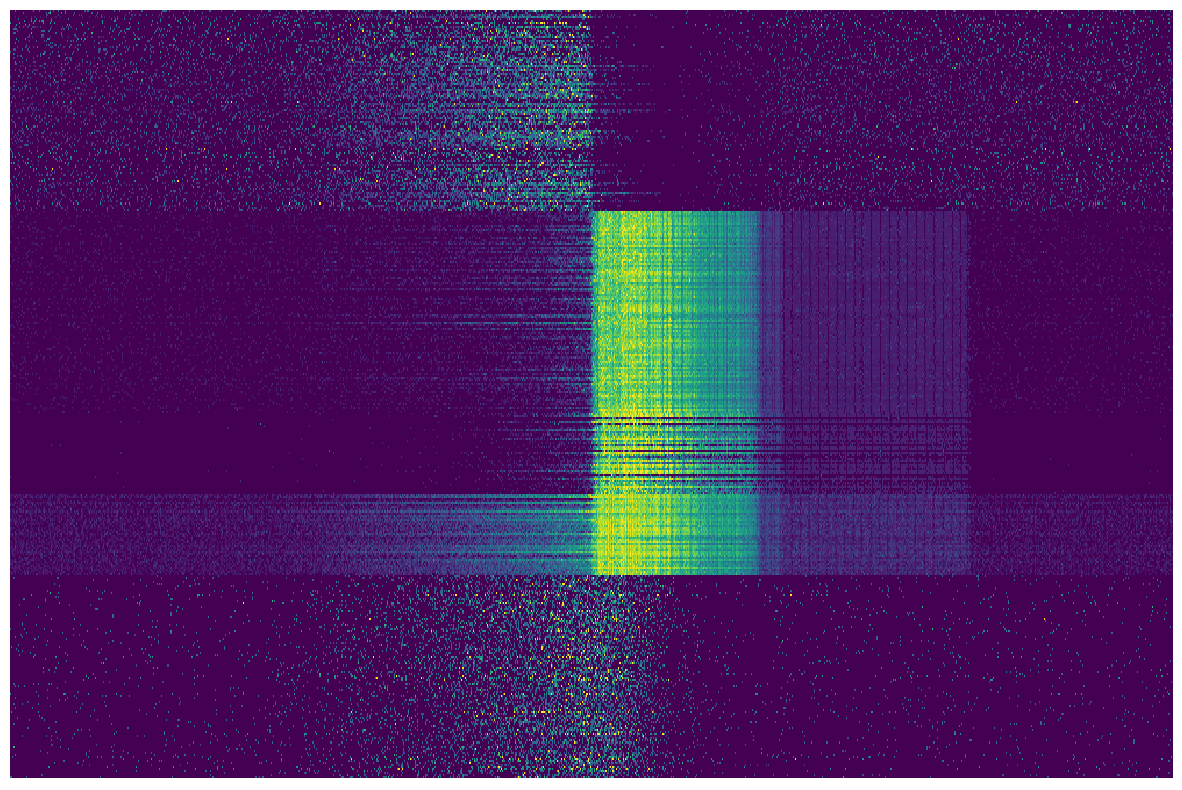

In [40]:
# get average firing pattern across trials
mean_cells = np.zeros([n_cells, int(trial_period/bin_size)])

for cell in range(n_cells):
    mean_current = []
    for switch in switch_times:
        start = round((switch - trial_period/2)/bin_size)
        end = round((switch + trial_period/2)/bin_size)
        mean_current += [all_cells[cell, start:end]]
    mean_current = np.mean(mean_current, axis = 0)
    mean_cells[cell] = mean_current/max(mean_current)

pylab.imshow(mean_cells, aspect = 'auto')
pylab.axis('off')